<a href="https://www.kaggle.com/code/fahmirk/scraping-e-ipo-data-using-selenium?scriptVersionId=136108373" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

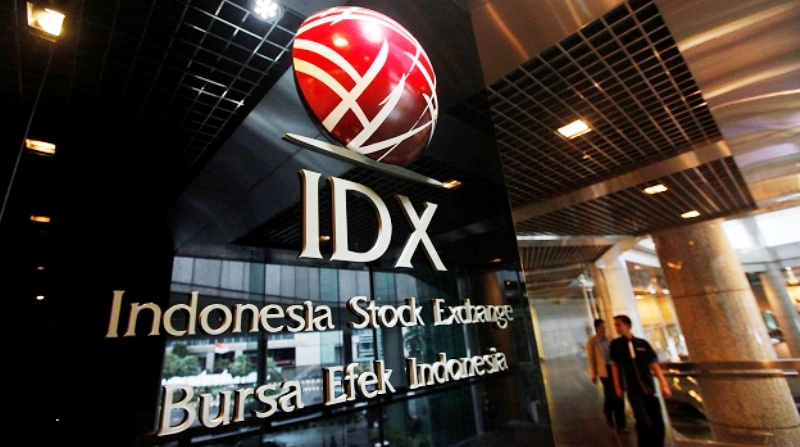<br>
<cite>Image from [m.cobisnis.com](https://m.cobisnis.com/tahun-2023-bei-targetkan-ipo-57-perusahaan)<cite>

## This notebook will explain how Chrome Driver and Selenium in Python can scrape data available on the e-IPO (Electronic Indonesia Public Offering) website in Realtime.

The notebook can be used to scrape all the company data available on the e-IPO website in real time, as long as the structure of the website is not changed (only the data of the company that is going to IPO is added).

**Notes**: If there is a change in the website structure, I may revise this notebook so that it can work properly.

**Disclaimer**: There may be some mistakes in this notebook because I am not an expert, but I'm glad it works. Some of the sources I used in making this notebook are Kaggle and Stack Overflow. I am very happy if you make this as a reference. Please criticize and suggest.

## Prerequisite

In [1]:
#Update
!apt-get update -y

#Installing the libraries used in this notebook
!apt-get install -y \
libglib2.0-0 \
libnss3 \
libdbus-glib-1-2 \
libgconf-2-4 \
libfontconfig1 \
gconf2-common \
libwayland-server0 \
libgbm1 \
udev \
libu2f-udev

#Fix any broken dependencies that might occur during the installation process
!sudo apt --fix-broken install -y

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Get:3 http://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [2356 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [474 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [37.5 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2529 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3346 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1070 kB]
Get:13 http://archive.ubuntu.com/ubuntu focal-upda

In [2]:
#Install google chrome
!wget -nc -P /usr/lib https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i /usr/lib/google-chrome-stable_current_amd64.deb

--2023-07-08 13:32:27--  https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
Resolving dl.google.com (dl.google.com)... 74.125.134.190, 74.125.134.91, 74.125.134.136, ...
Connecting to dl.google.com (dl.google.com)|74.125.134.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94327756 (90M) [application/x-debian-package]
Saving to: ‘/usr/lib/google-chrome-stable_current_amd64.deb’

google-chrome-stabl 100%[===================>]  89.96M   132MB/s    in 0.7s    

2023-07-08 13:32:27 (132 MB/s) - ‘/usr/lib/google-chrome-stable_current_amd64.deb’ saved [94327756/94327756]

Selecting previously unselected package google-chrome-stable.
(Reading database ... 110153 files and directories currently installed.)
Preparing to unpack .../google-chrome-stable_current_amd64.deb ...
Unpacking google-chrome-stable (114.0.5735.198-1) ...
Setting up google-chrome-stable (114.0.5735.198-1) ...
update-alternatives: using /usr/bin/google-chrome-stable to prov

In [3]:
#Install chromedriver
!wget -nc -P /usr/lib https://chromedriver.storage.googleapis.com/114.0.5735.90/chromedriver_linux64.zip

--2023-07-08 13:32:36--  https://chromedriver.storage.googleapis.com/114.0.5735.90/chromedriver_linux64.zip
Resolving chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)... 173.194.218.128, 2607:f8b0:400c:c14::80
Connecting to chromedriver.storage.googleapis.com (chromedriver.storage.googleapis.com)|173.194.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7407250 (7.1M) [application/zip]
Saving to: ‘/usr/lib/chromedriver_linux64.zip’

chromedriver_linux6 100%[===================>]   7.06M  --.-KB/s    in 0.04s   

2023-07-08 13:32:36 (200 MB/s) - ‘/usr/lib/chromedriver_linux64.zip’ saved [7407250/7407250]



In [4]:
#Create new directory named "Chrome-browser"
!mkdir /usr/lib/chrome-browser

#Unzip chromedriver_linux64.zip and extracts its contents to "/usr/lib/chrome-browser/" directory
!unzip -o /usr/lib/chromedriver_linux64.zip -d /usr/lib/chrome-browser/

Archive:  /usr/lib/chromedriver_linux64.zip
  inflating: /usr/lib/chrome-browser/chromedriver  
  inflating: /usr/lib/chrome-browser/LICENSE.chromedriver  


In [5]:
#Install Selenium
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 30.1 MB/s eta 0:00:00


## Preparation

First, import all libraries used in this notebook

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver import ChromeOptions
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import NoSuchElementException
import re
import pandas as pd
from PIL import Image
import sys
import numpy as np
import time
from io import BytesIO
sys.path.insert(0,'/usr/lib/chrome-browser/chromedriver')
pd.set_option('display.max_columns', None)

Here I created some functions that are used in this notebook to make work easier.

In [7]:
#Function
def Status_IPO(text):
    klasifikasi = ["Pre-Effective",
               "Book Building",
               "Offering",
               "Allotment",
               "Closed",
               "Canceled"]
    klasifikasi = klasifikasi[::-1]
    status = [item for item in klasifikasi if item in text]
    if len(set(status)) == 1:
        return(status[0])
    else:
        status.remove("Book Building")
        return(status[0])
    
def is_string_unique(string, lst):
    return lst.count(string) == 1

def book_building_period(text):
    if is_string_unique("Book Building",text):
        return(data[data.index("Book Building") + 1])
    else:
        return(data[data.index("Book Building",data.index("Book Building") + 1) + 1])

def book_building_price(text):
    if is_string_unique("Book Building",text):
        return(data[data.index("Book Building") + 2])
    else:
        return(data[data.index("Book Building",data.index("Book Building") + 1) + 2])

def convert_to_integer(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(',', '', regex=True).where(df[column].notnull(), np.nan)
        df[column] = df[column].str.replace('IDR ', '').astype('Int64').where(df[column].notnull(), np.nan)
    return df

def warrant_per_share_ratio(warantdata):
    if warantdata is None:
        return np.nan
    elif ':' in warantdata:
        warantdata = warantdata.split(':')
        return (float(warantdata[1]) / float(warantdata[0]))
    else:
        return warantdata

def extract_underwriters(df, column):
    df[column] = df[column].apply(lambda x: [re.sub(r'\s*-\s*.*$', '', item) for item in x])
    df[column] = df[column].apply(lambda x: ','.join(x))
    return df[column]

def extract_participant_admin(df, column):
    df[column] = df[column].apply(lambda x: re.sub(r'\s*-\s*.*$', '', x))
    return df[column]
    
def update_database(data):
    #Mengambil data dari halaman perusahaan yang akan melakukan IPO
    newvalue = [
        None,  # Placeholder for Status_IPO
        None,  # Placeholder for Nama
        None,  # Placeholder for Kode
        None,  # Placeholder for Sektor
        None,  # Placeholder for Subsektor
        None,  # Placeholder for LOB
        None,  # Placeholder for Address
        None,  # Placeholder for Website
        None,  # Placeholder for Shares_offered
        None,  # Placeholder for Percentage_total_shares
        None,  # Placeholder for Participant_admin
        None,  # Placeholder for UW
        None,  # Placeholder for BB_Period
        None,  # Placeholder for BB_Price
        None,  # Placeholder for Offering_Period
        None,  # Placeholder for Final_Price
        None,  # Placeholder for Allotment
        None,  # Placeholder for Distribution
        None,  # Placeholder for Listing
        None,  # Placeholder for Warrant
        None   # Placeholder for Exercise
    ]

    try:
        newvalue[0] = Status_IPO(data)
    except ValueError:
        pass

    try:
        newvalue[1] = data[0]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[2] = data[2]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[3] = data[data.index("Sector") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[4] = data[data.index("Subsector") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[5] = data[data.index("Line Of Business") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[6] = data[data.index("Address") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[7] = data[data.index("Website") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[8] = int(re.sub(r'[^\d]', '', data[data.index("Number of shares offered") + 1]))
    except (ValueError, IndexError):
        pass

    try:
        newvalue[9] = float(data[data.index("% of Total Shares") + 1])
    except (ValueError, IndexError):
        pass

    try:
        newvalue[10] = data[data.index("Participant Admin") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[11] = data[data.index("Underwriter(s)")+1:data.index(Status_IPO(data))]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[12] = book_building_period(data)
    except (ValueError, IndexError):
        pass

    try:
        newvalue[13] = book_building_price(data)
    except (ValueError, IndexError):
        pass

    try:
        if is_string_unique("Offering",data):
            newvalue[14] = data[data.index("Offering") + 1]
        else:
            newvalue[14] = data[data.index("Offering") + 2]
    except (ValueError, IndexError):
        pass

    try:
        if is_string_unique("Offering",data):
            newvalue[15] = data[data.index("Offering") + 2]
        else:
            newvalue[15] = data[data.index("Offering") + 3]
    except (ValueError, IndexError):
        pass
    try:
        newvalue[16] = data[data.index("Allotment (Closing)") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[17] = data[data.index("Distribution") + 1]
    except (ValueError, IndexError):
        pass

    try:
        newvalue[18] = data[data.index("Listing Date") + 1]
    except (ValueError, IndexError):
        pass
    
    try:
        newvalue[19] = data[data.index("Warant") + 1]
    except (ValueError, IndexError):
        pass
    
    try:
        if "IDR" not in data[data.index("Exercise Price") + 1]:
            raise ValueError
        else:
            newvalue[20] = data[data.index("Exercise Price") + 1]
    except (ValueError, IndexError):
        pass
    
    #Update Data
    for key, new_value in zip(database.keys(), newvalue):
        database[key].append(new_value)

## Scraping Data Website e-IPO

After importing the libraries and declaring some functions, we can start extracting information from the e-IPO website. (https://www.e-ipo.co.id/en/ipo/index)

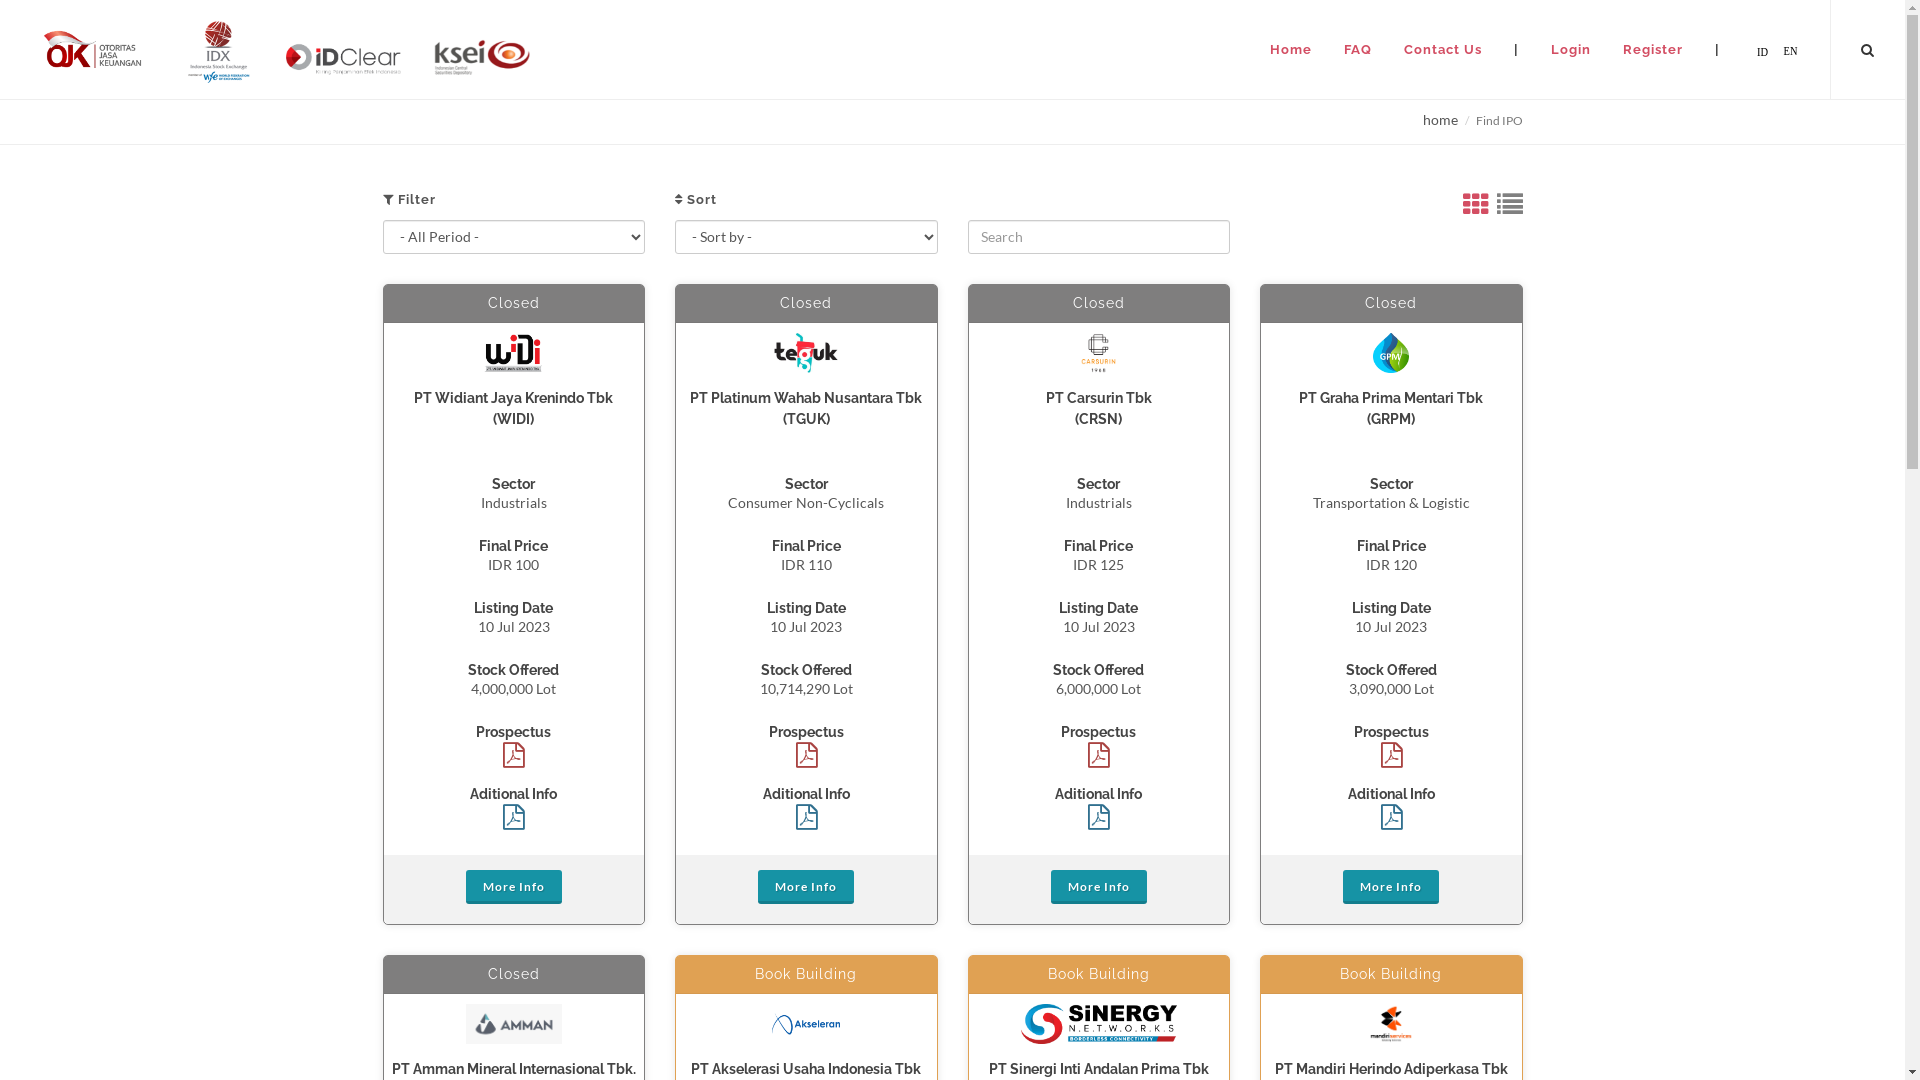

In [8]:
#Create Connection
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')                             
options.add_argument('--disable-dev-shm-usage')
options.add_argument('user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36')
options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(service=Service(executable_path='/usr/lib/chrome-browser/chromedriver'),options=options)


url = "https://www.e-ipo.co.id/en/ipo/index"
driver.get(url)

time.sleep(3) #Wait 3 seconds for the website to display perfectly so we can get a screenshot in the next code

#Take a screenshot of the website and display it.
img = Image.open(BytesIO(driver.get_screenshot_as_png()))
img

It is known that on each page there are 12 companies, so on each page we will iterate to retrieve company information **12 times**, shown with the following code:
>for j in range(12):

On the last page, it may happen that the list of companies is **less than or equal to 12**, so I will use the "break" statement to stop the process like this:
>try:<br>
>&emsp;link = row.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')<br>
>except NoSuchElementException:<br>
>&emsp;print('Page ' + str(i) + ': Success. There is no more information')<br>
>&emsp;break

In [9]:
#Create a database in the form of a dictionary
keyList = ["IPO Status",
           "Ticker Code",
           "Company Name",
           "Sector",
           "Subsector",
           "Line of Business",
           "Address",
           "Website",
           "Number of shares offered",
           "% of Total Shares",
           "Participant Admin",
           "Underwriter(s)",
           "Book Building Period",
           "Book Building Price",
           "Offering Period",
           "Final Price (Rp)",
           "Closing Date",
           "Distribution Date",
           "Listing Date",
           "Warrant",
           "Exercise Price (Warrant) (Rp)"
          ]

database = {key: [] for key in keyList}

#Iterations for each page
timeout = 10 # The process is stopped when the website does not respond within 10 seconds.

i=1 #Set i for iteration


print("Data Scraping Process")
driver.get(url)

while True:
    driver.get('https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12')
    
    #Looking for an element that holds a list of companies so that we can search for links to each company
    row = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]')

    try:
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.XPATH, '/*')))

    except TimeoutException:
        print("Timed out waiting for Response")
        break
            
    #Iteration to retrieve information from each company that will conduct an IPO on each page.
    for j in range(12):
        #Each company's link will appear in the "link" variable
        try:
            link = row.find_element(By.XPATH,'//*[@id="w0"]/div[1]/div['+str(j+1)+']/div/div/div[5]/a').get_attribute('href')
        
        except NoSuchElementException:
            print('Page ' + str(i) + ': Success. There is no more information')
            break

        #Access company links
        driver.get(link)
        
        #This script will be used in "WebDriverWait" so that the next code will run when the element with ID "wrapper"
        #has animationDuration equal to "1.5s" and opacity equal to "1".
        #Once the conditions are met,the Python code execution will continue.
        script = """
            var element = document.getElementById("wrapper");
            var styles = window.getComputedStyle(element);
            var animationDuration = styles.animationDuration;
            var opacity = styles.opacity;
            return (animationDuration === "1.5s" && opacity === "1");
        """
        try:
            WebDriverWait(driver, timeout).until(lambda driver: driver.execute_script(script))
            
            #The company information is taken from the element in '//*[@id="wrapper"]/section[2]/div/div/div[2]'
            #which is converted into text. Then the resulting text is converted into a list with a delimiter '\n' (New Line)
            #and this list will be declared as a new variable called "data".
            data = driver.find_element(By.XPATH,'//*[@id="wrapper"]/section[2]/div/div/div[2]').text.split('\n')

        except TimeoutException:
            print("Timed out waiting for Response")
            break
        
        #Update the database with functions that have been created in the preparation step.
        update_database(data)

        #Exit from the company page
        driver.get('https://www.e-ipo.co.id/en/ipo/index?page=' + str(i) + '&per-page=12')
        row = driver.find_element(By.XPATH,'//*[@id="w0"]/div[1]')
    else:
        print("Page " + str(i) + " : Success")
        i += 1
        continue
    print("Process Completed")
    break

Data Scraping Process
Page 1 : Success
Page 2 : Success
Page 3 : Success
Page 4 : Success
Page 5 : Success
Page 6 : Success
Page 7 : Success
Page 8 : Success
Page 9 : Success
Page 10 : Success
Page 11 : Success
Page 12 : Success
Page 13: Success. There is no more information
Process Completed


After the data is stored in the form of a dictionary, the data will be displayed in the form of a Pandas DataFrame.

In [10]:
#Stores the database in the form of a dictionary into a pandas DataFrame
table = pd.DataFrame.from_dict(database)
table

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Period,Book Building Price,Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant,Exercise Price (Warrant) (Rp)
0,Closed,PT Widiant Jaya Krenindo Tbk,WIDI,Industrials,Construction Machinery & Heavy Vehicles,Bergerak dalam Bidang Jasa Sewa Alat Berat Bes...,"Jl. Teh No. 4-6, RT.7/RW.3, Kel. Pinangsia, Ke...",https://www.ptwidi.com/,400000000,25.00,SH - ARTHA SEKURITAS INDONESIA,[SH - ARTHA SEKURITAS INDONESIA],16 Jun 2023 - 22 Jun 2023,IDR 100 - IDR 115,04 Jul 2023 - 06 Jul 2023,IDR 100,06 Jul 2023,07 Jul 2023,10 Jul 2023,20 : 21,IDR 120
1,Closed,PT Platinum Wahab Nusantara Tbk,TGUK,Consumer Non-Cyclicals,Food Retail & Distributors,Makanan dan Minuman,Ruko Golden Square Blok GS No. 2 Jl. Ciater Ra...,https://teguk.co.id/,1071429000,30.00,MG - SEMESTA INDOVEST SEKURITAS,[MG - SEMESTA INDOVEST SEKURITAS],19 Jun 2023 - 23 Jun 2023,IDR 105 - IDR 112,04 Jul 2023 - 06 Jul 2023,IDR 110,06 Jul 2023,07 Jul 2023,10 Jul 2023,5 : 2,IDR 152
2,Closed,PT Carsurin Tbk,CRSN,Industrials,Business Support Services,"Testing, Inspection, Certification","SOHO CAPITAL, 28th Floor Jl. Letjen S. Parman ...",https://www.carsurin.com,600000000,20.75,XA - NH KORINDO SEKURITAS INDONESIA,[XA - NH KORINDO SEKURITAS INDONESIA],16 Jun 2023 - 21 Jun 2023,IDR 120 - IDR 125,04 Jul 2023 - 06 Jul 2023,IDR 125,06 Jul 2023,07 Jul 2023,10 Jul 2023,None,None
3,Closed,PT Graha Prima Mentari Tbk,GRPM,Transportation & Logistic,Logistics & Deliveries,Bidang Usaha Distribusi Minuman Berkarbonasi,Jl. Tuparev No. 87A. Cirebon - Jawa Barat,https://grahaprimamentari.co.id/,309000000,20.00,XA - NH KORINDO SEKURITAS INDONESIA,[XA - NH KORINDO SEKURITAS INDONESIA],15 Jun 2023 - 20 Jun 2023,IDR 120 - IDR 130,04 Jul 2023 - 06 Jul 2023,IDR 120,06 Jul 2023,07 Jul 2023,10 Jul 2023,2 : 1,IDR 250
4,Closed,PT Amman Mineral Internasional Tbk.,AMMN,Basic Materials,Copper,Aktivitas Perusahaan Holding,"Gedung Menara Karya Lantai 6 Unit A, B, C dan ...",https://www.amman.co.id,6328208800,8.80,CC - MANDIRI SEKURITAS,"[CC - MANDIRI SEKURITAS, DP - DBS VICKERS SEKU...",31 May 2023 - 16 Jun 2023,"IDR 1,650 - IDR 1,775",03 Jul 2023 - 05 Jul 2023,"IDR 1,695",05 Jul 2023,06 Jul 2023,07 Jul 2023,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Closed,PT Bundamedik Tbk,BMHS,Healthcare,Healthcare Providers,Bergerak di bidang aktivitas rumah sakit swast...,"Jl. Teuku Cik Ditiro No. 28, Menteng Jakarta 1...",https://www.bmhs.co.id,620000000,7.26,KI - CIPTADANA SEKURITAS ASIA,[KI - CIPTADANA SEKURITAS ASIA],17 Jun 2021 - 22 Jun 2021,IDR 300 - IDR 350,30 Jun 2021 - 02 Jul 2021,IDR 340,02 Jul 2021,05 Jul 2021,06 Jul 2021,None,None
141,Closed,PT Bank Multiarta Sentosa Tbk,MASB,Financials,Banks,Bank,None,https://www.bankmas.co.id,186176500,15.00,SQ - BCA SEKURITAS,[SQ - BCA SEKURITAS],07 Jun 2021 - 15 Jun 2021,"IDR 3,000 - IDR 4,000",24 Jun 2021 - 28 Jun 2021,"IDR 3,360",28 Jun 2021,29 Jun 2021,30 Jun 2021,1 : 1,"IDR 3,500"
142,Closed,PT Archi Indonesia Tbk,ARCI,Basic Materials,Gold,Perusahaan holding di bidang pertambangan mine...,"Menara Rajawali, Lantai 19, Jl. DR Ide Anak Ag...",https://www.archiindonesia.com,3725250000,15.00,AI - UOB KAY HIAN SEKURITAS,"[AI - UOB KAY HIAN SEKURITAS, CC - MANDIRI SEK...",31 May 2021 - 09 Jun 2021,IDR 750 - IDR 800,22 Jun 2021 - 24 Jun 2021,IDR 750,24 Jun 2021,25 Jun 2021,28 Jun 2021,None,None
143,Closed,PT Ulima Nitra Tbk,UNIQ,Energy,"Oil, Gas & Coal Equipment & Services",Jasa Pertambangan dan Jasa Sewa Menyewa Perala...,"JL. Betet No. 28 RT 22/ RW 9, 9 Ilir, Ilir Tim...",https://www.ulimanitra.co.id,300000000,9.56,SF - SURYA FAJAR SEKURITAS,[SF - SURYA FAJAR SEKURITAS],17 Feb 2021 - 19 Feb 2021,IDR 115 - IDR 118,02 Mar 2021 - 04 Mar 2021,IDR 118,04 Mar 2021,05 Mar 2021,08 Mar 2021,None,None


Currently, the data is stored in the DataFrame. For the purpose of further analysis, the data is modified as follows:
1. Changing the columns containing date period data such as "Book Building Period" and "Offer Period" into 2 separate columns, namely the opening and closing columns.
2. Converting the Book Building Price from a range into two separate columns for the opening and closing prices.
3. Converting the price data into integer form.
4. Converting the security data into only the security code.
5. Converting the warrant data into the form of warrant per share ratio.
6. Converting columns containing categorical data into category form and converting columns containing date data into DateTime form

In [11]:
#Separates the column containing the range into two separate columns of opening and closing or lowest and highest.
table[['Book Building Opening', 'Book Building Closing']] = table['Book Building Period'].str.split(' - ', expand=True)
table.drop('Book Building Period', axis=1, inplace=True)
table.insert(12, 'Book Building Opening', table.pop('Book Building Opening'))
table.insert(13, 'Book Building Closing', table.pop('Book Building Closing'))

table[['Lowest Book Building Price (Rp)', 'Highest Book Building Price (Rp)']] = table['Book Building Price'].str.split(' - ', expand=True)
table.drop('Book Building Price', axis=1, inplace=True)
table.insert(14, 'Lowest Book Building Price (Rp)', table.pop('Lowest Book Building Price (Rp)'))
table.insert(15, 'Highest Book Building Price (Rp)', table.pop('Highest Book Building Price (Rp)'))

table[['Opening of Offering Period', 'Closing of Offering Period']] = table['Offering Period'].str.split(' - ', expand=True)
table.drop('Offering Period', axis=1, inplace=True)
table.insert(16, 'Opening of Offering Period', table.pop('Opening of Offering Period'))
table.insert(17, 'Closing of Offering Period', table.pop('Closing of Offering Period'))

#Convert the column containing the price to an integer
table = convert_to_integer(table, ['Lowest Book Building Price (Rp)',
                                   'Highest Book Building Price (Rp)',
                                   'Final Price (Rp)',
                                   'Exercise Price (Warrant) (Rp)'])

#Extract the column containing the security name to just the code and convert it to categorical form
extract_underwriters(table, 'Underwriter(s)')
extract_participant_admin(table, "Participant Admin")

#Converting warrant data into the form of warrant per share ratio
table['Warrant'] = table['Warrant'].apply(warrant_per_share_ratio)
table = table.rename(columns={'Warrant': 'Warrant per share ratio'})

#Convert columns containing date data into DateTime form
listdate_column = ["Book Building Opening",
                  "Book Building Closing",
                  "Opening of Offering Period",
                  "Closing of Offering Period",
                  "Closing Date",
                  "Distribution Date",
                  "Listing Date"]
table[listdate_column] = table[listdate_column].apply(pd.to_datetime)

#Convert columns containing categorical data into category form
listcategory_column = ["IPO Status",
                      "Sector",
                      "Subsector",
                      "Participant Admin",
                      "Underwriter(s)"]
table[listcategory_column] = table[listcategory_column].apply(lambda x: x.astype('category'))

#Display DataFrame
table.head()

,IPO Status,Ticker Code,Company Name,Sector,Subsector,Line of Business,Address,Website,Number of shares offered,% of Total Shares,Participant Admin,Underwriter(s),Book Building Opening,Book Building Closing,Lowest Book Building Price (Rp),Highest Book Building Price (Rp),Opening of Offering Period,Closing of Offering Period,Final Price (Rp),Closing Date,Distribution Date,Listing Date,Warrant per share ratio,Exercise Price (Warrant) (Rp)
0,Closed,PT Widiant Jaya Krenindo Tbk,WIDI,Industrials,Construction Machinery & Heavy Vehicles,Bergerak dalam Bidang Jasa Sewa Alat Berat Bes...,"Jl. Teh No. 4-6, RT.7/RW.3, Kel. Pinangsia, Ke...",https://www.ptwidi.com/,400000000,25.00,SH,SH,2023-06-16,2023-06-22,100,115,2023-07-04,2023-07-06,100,2023-07-06,2023-07-07,2023-07-10,1.05,120
1,Closed,PT Platinum Wahab Nusantara Tbk,TGUK,Consumer Non-Cyclicals,Food Retail & Distributors,Makanan dan Minuman,Ruko Golden Square Blok GS No. 2 Jl. Ciater Ra...,https://teguk.co.id/,1071429000,30.00,MG,MG,2023-06-19,2023-06-23,105,112,2023-07-04,2023-07-06,110,2023-07-06,2023-07-07,2023-07-10,0.40,152
2,Closed,PT Carsurin Tbk,CRSN,Industrials,Business Support Services,"Testing, Inspection, Certification","SOHO CAPITAL, 28th Floor Jl. Letjen S. Parman ...",https://www.carsurin.com,600000000,20.75,XA,XA,2023-06-16,2023-06-21,120,125,2023-07-04,2023-07-06,125,2023-07-06,2023-07-07,2023-07-10,NaN,<NA>
3,Closed,PT Graha Prima Mentari Tbk,GRPM,Transportation & Logistic,Logistics & Deliveries,Bidang Usaha Distribusi Minuman Berkarbonasi,Jl. Tuparev No. 87A. Cirebon - Jawa Barat,https://grahaprimamentari.co.id/,309000000,20.00,XA,XA,2023-06-15,2023-06-20,120,130,2023-07-04,2023-07-06,120,2023-07-06,2023-07-07,2023-07-10,0.50,250
4,Closed,PT Amman Mineral Internasional Tbk.,AMMN,Basic Materials,Copper,Aktivitas Perusahaan Holding,"Gedung Menara Karya Lantai 6 Unit A, B, C dan ...",https://www.amman.co.id,6328208800,8.80,CC,"CC,DP,IF,KZ,NI,OD,ZP",2023-05-31,2023-06-16,1650,1775,2023-07-03,2023-07-05,1695,2023-07-05,2023-07-06,2023-07-07,NaN,<NA>


In [12]:
#View the data type of each column in the DataFrame
table.dtypes

IPO Status                                category
Ticker Code                                 object
Company Name                                object
Sector                                    category
Subsector                                 category
Line of Business                            object
Address                                     object
Website                                     object
Number of shares offered                     int64
% of Total Shares                          float64
Participant Admin                         category
Underwriter(s)                            category
Book Building Opening               datetime64[ns]
Book Building Closing               datetime64[ns]
Lowest Book Building Price (Rp)              Int64
Highest Book Building Price (Rp)             Int64
Opening of Offering Period          datetime64[ns]
Closing of Offering Period          datetime64[ns]
Final Price (Rp)                             Int64
Closing Date                   

The data has been collected and is ready to be exported into CSV.

In [13]:
#Save DataFrame to CSV
table.to_csv("e-IPO Data.csv", index=False)